<a href="https://colab.research.google.com/github/rygo1232/ryan1/blob/main/DP_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
#!pip install bayesian-optimization


# **new model**

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from google.colab import drive
tfd = tfp.distributions

# **Data Preparation**

In [46]:
# Mount Google Drive
drive.mount('/content/drive')

# Load and prepare data
def load_and_prepare_data(file_path):
    # Load data
    opr_data = pd.read_excel(file_path)

    # Handle missing values
    opr_data.fillna(method='ffill', inplace=True)

    # Encode categorical features
    categorical_cols = opr_data.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        opr_data[col] = le.fit_transform(opr_data[col])
        label_encoders[col] = le

    # Scale numerical features
    numerical_cols = opr_data.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    opr_data[numerical_cols] = scaler.fit_transform(opr_data[numerical_cols])

    # Prepare features and target
    X = opr_data.drop('loss', axis=1, errors='ignore')
    y = opr_data['loss']

    # Shuffle and split
    X, y = shuffle(X, y, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    return X_train, X_test, y_train, y_test, scaler, label_encoders

# Load your data
file_path = '/content/drive/MyDrive/Colab Notebooks/OPR_Data.xlsx'
X_train, X_test, y_train, y_test, scaler, label_encoders = load_and_prepare_data(file_path)

# Print the shapes to verify
print("Shapes after conversion:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shapes after conversion:
X_train shape: (36, 8), y_train shape: (36, 1)
X_test shape: (9, 8), y_test shape: (9, 1)


<ipython-input-46-904e052b2c7a>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  opr_data.fillna(method='ffill', inplace=True)


# **ANN Model**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.7582 - mae: 0.6702 - val_loss: 1.4900 - val_mae: 0.9763
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.6554 - mae: 0.6597 - val_loss: 1.2797 - val_mae: 0.9113
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.5330 - mae: 0.5869 - val_loss: 1.1164 - val_mae: 0.8580
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.5126 - mae: 0.5817 - val_loss: 0.9746 - val_mae: 0.8082
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.4754 - mae: 0.5363 - val_loss: 0.8631 - val_mae: 0.7673
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3902 - mae: 0.4839 - val_loss: 0.7714 - val_mae: 0.7319
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.4065 - mae: 0.5149 - val_loss: 0.6903 - val_mae: 0.6964
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.3756 - mae: 0.4876 - val_loss: 0.6255 - val_mae: 0.6662
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3538 - mae: 0.4433 - va

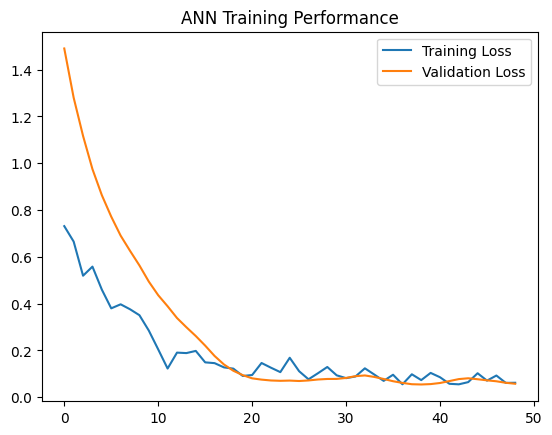


ANN Evaluation:
MSE: 0.0543
MAE: 0.1809
R²: 0.9530


In [47]:
def build_train_ann(X_train, y_train, X_test, y_test):
    # Model architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    # Compile and train
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                       validation_data=(X_test, y_test),
                       epochs=100, batch_size=32,
                       callbacks=[early_stopping], verbose=1)

    # Evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot results
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('ANN Training Performance')
    plt.legend()
    plt.show()

    print(f"\nANN Evaluation:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")
    return model, history

# Run the ANN
ann_model, ann_history = build_train_ann(X_train, y_train, X_test, y_test)

# **ANN Model 2**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - loss: 2.2552 - mae: 0.7335 - val_loss: 2.8653 - val_mae: 0.8755
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2.1884 - mae: 0.6934 - val_loss: 2.7068 - val_mae: 0.8340
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.1265 - mae: 0.6755 - val_loss: 2.5830 - val_mae: 0.7978
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.0107 - mae: 0.5951 - val_loss: 2.4804 - val_mae: 0.7638
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.8981 - mae: 0.5531 - val_loss: 2.3864 - val_mae: 0.7373
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.8535 - mae: 0.5538 - val_loss: 2.2845 - val_mae: 0.7104
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.8175 - mae: 0.5172 - val_loss: 2.1891 - val_mae: 0.6881
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.7261 - mae: 0.4821 - val_loss: 2.1003 - val_mae: 0.6683
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.7407 - mae: 0.5045 - va

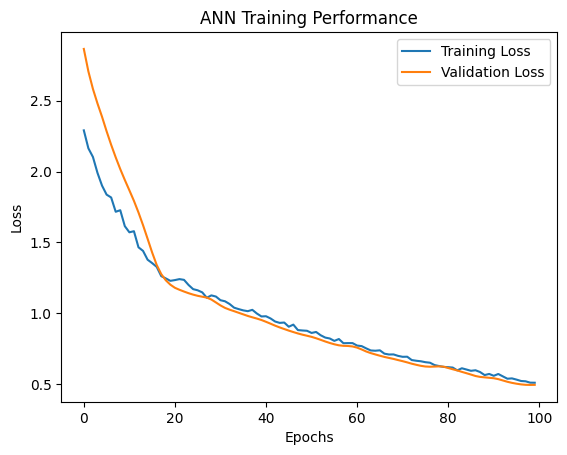


ANN Evaluation:
MSE: 0.0132
MAE: 0.0987
R²: 0.9886


In [48]:

def build_train_ann(X_train, y_train, X_test, y_test):
    # Model architecture with L2 Regularization
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
        Dropout(0.3),  # Dropout layer to reduce overfitting
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Optional L2 Regularization
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Optional L2 Regularization
        Dense(1)
    ])

    # Compile and train
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=100, batch_size=32,
                        callbacks=[early_stopping], verbose=1)

    # Evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot results
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('ANN Training Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"\nANN Evaluation:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")
    return model, history

# Run the ANN
ann_model, ann_history = build_train_ann(X_train, y_train, X_test, y_test)

# **LSTM Model**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - loss: 0.9598 - mae: 0.7910

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.8973 - mae: 0.7573 - val_loss: 1.3280 - val_mae: 0.8522 - learning_rate: 8.0000e-04
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - loss: 0.6857 - mae: 0.6583

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.7749 - mae: 0.7008 - val_loss: 1.2581 - val_mae: 0.8311 - learning_rate: 8.0000e-04
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.8145 - mae: 0.7081

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.7936 - mae: 0.7069 - val_loss: 1.1822 - val_mae: 0.8085 - learning_rate: 8.0000e-04
Epoch 4/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.6296 - mae: 0.6570

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.6966 - mae: 0.6756 - val_loss: 1.1024 - val_mae: 0.7838 - learning_rate: 8.0000e-04
Epoch 5/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.7634 - mae: 0.7065

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.7251 - mae: 0.6835 - val_loss: 1.0139 - val_mae: 0.7557 - learning_rate: 8.0000e-04
Epoch 6/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7098 - mae: 0.6689

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.6856 - mae: 0.6620 - val_loss: 0.9318 - val_mae: 0.7281 - learning_rate: 8.0000e-04
Epoch 7/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.6453 - mae: 0.6479

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.6529 - mae: 0.6519 - val_loss: 0.8480 - val_mae: 0.6986 - learning_rate: 8.0000e-04
Epoch 8/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.5671 - mae: 0.6397

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.5891 - mae: 0.6372 - val_loss: 0.7592 - val_mae: 0.6655 - learning_rate: 8.0000e-04
Epoch 9/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6492 - mae: 0.6756

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.6053 - mae: 0.6403 - val_loss: 0.6737 - val_mae: 0.6313 - learning_rate: 8.0000e-04
Epoch 10/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5448 - mae: 0.6069

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.5541 - mae: 0.6138 - val_loss: 0.5946 - val_mae: 0.5971 - learning_rate: 8.0000e-04
Epoch 11/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4748 - mae: 0.5563

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.5034 - mae: 0.5814 - val_loss: 0.5226 - val_mae: 0.5703 - learning_rate: 8.0000e-04
Epoch 12/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4000 - mae: 0.5419

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.4683 - mae: 0.5764 - val_loss: 0.4490 - val_mae: 0.5475 - learning_rate: 8.0000e-04
Epoch 13/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4073 - mae: 0.5484

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4462 - mae: 0.5649 - val_loss: 0.3715 - val_mae: 0.5189 - learning_rate: 8.0000e-04
Epoch 14/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4420 - mae: 0.5469

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.4300 - mae: 0.5435 - val_loss: 0.3023 - val_mae: 0.4885 - learning_rate: 8.0000e-04
Epoch 15/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4258 - mae: 0.5514

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.4078 - mae: 0.5391 - val_loss: 0.2435 - val_mae: 0.4546 - learning_rate: 8.0000e-04
Epoch 16/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4218 - mae: 0.5480

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.3983 - mae: 0.5269 - val_loss: 0.2036 - val_mae: 0.4233 - learning_rate: 8.0000e-04
Epoch 17/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3797 - mae: 0.4894

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.3822 - mae: 0.4928 - val_loss: 0.1831 - val_mae: 0.4007 - learning_rate: 8.0000e-04
Epoch 18/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3591 - mae: 0.4698

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.3585 - mae: 0.4762 - val_loss: 0.1782 - val_mae: 0.3910 - learning_rate: 8.0000e-04
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.3927 - mae: 0.5057 - val_loss: 0.1823 - val_mae: 0.3920 - learning_rate: 8.0000e-04
Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3504 - mae: 0.4847 - val_loss: 0.1933 - val_mae: 0.4053 - learning_rate: 8.0000e-04
Epoch 21/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.3038 - mae: 0.4676 - val_loss: 0.2117 - val_mae: 0.4305 - learning_rate: 8.0000e-04
Epoch 22/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.3362 - mae: 0.4768 - val_loss: 0.2358 - val_mae: 0.4627 - learning_rate: 8.0000e-04
Epoch 23/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.3165 - mae: 0.4830 - val_loss: 0.2626 - val_mae: 0.4954 - learning_rate: 8.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


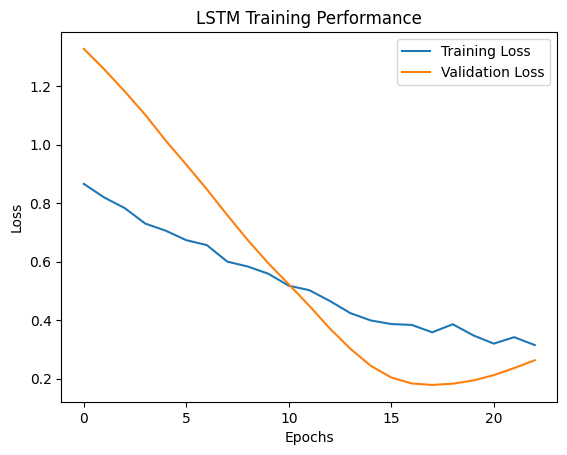


LSTM Evaluation:
MSE: 0.1782
MAE: 0.3910
R²: 0.8458


In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_train_lstm(X_train, y_train, X_test, y_test):
    # Reshape data for LSTM
    X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Model architecture
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.3),
        LSTM(32, return_sequences=False, activation='tanh'),  # Removed activation for last LSTM
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    # Compile and train
    model.compile(optimizer=Adam(learning_rate=0.0008), loss='mse', metrics=['mae'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)

    # Training process
    history = model.fit(X_train_seq, y_train,
                        validation_data=(X_test_seq, y_test),
                        epochs=100, batch_size=32,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr],
                        verbose=1)

    # Evaluate
    y_pred = model.predict(X_test_seq)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot results
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Training Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"\nLSTM Evaluation:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")

    return model, history

# Run the LSTM
lstm_model, lstm_history = build_train_lstm(X_train, y_train, X_test, y_test)

# Autoencoder

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - loss: 1.1693 - val_loss: 1.5262
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.1743 - val_loss: 1.5171
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.1591 - val_loss: 1.5075
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.1497 - val_loss: 1.4967
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 1.1486 - val_loss: 1.4846
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.1449 - val_loss: 1.4718
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.0898 - val_loss: 1.4571
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.0941 - val_loss: 1.4381
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.1070 - val_loss: 1.4161
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.0592 - val_loss: 1.3914
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.0590 - val_loss: 1.3622
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.0487 - val

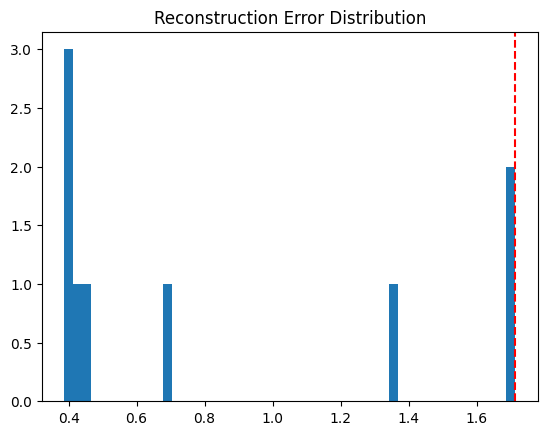


Anomalies detected: 1/9


In [50]:
def build_train_autoencoder(X_train, X_test):
    # Model architecture
    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')

    # Train
    history = model.fit(X_train, X_train,
                       epochs=100, batch_size=32,
                       validation_data=(X_test, X_test),
                       verbose=1)

    # Detect anomalies
    X_test_pred = model.predict(X_test)
    reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=1)
    threshold = np.percentile(reconstruction_error, 95)
    anomalies = reconstruction_error > threshold

    # Plot results
    plt.hist(reconstruction_error, bins=50)
    plt.axvline(threshold, color='r', linestyle='--')
    plt.title('Reconstruction Error Distribution')
    plt.show()

    print(f"\nAnomalies detected: {sum(anomalies)}/{len(anomalies)}")
    return model, reconstruction_error

# Run the autoencoder
autoencoder, reconstruction_error = build_train_autoencoder(X_train, X_test)

# **Bayesian Neural Network**

In [67]:
def build_train_bnn(X_train, y_train, X_test, y_test):
    # Define BNN using DenseFlipout for uncertainty estimation
    # The inputs variable was not defined, it should be the Input layer
    inputs = Input(shape=(X_train.shape[1],))
    x = tfp.layers.DenseFlipout(64, activation='relu')(inputs)
    x = tfp.layers.DenseFlipout(32, activation='relu')(x)
    outputs = tfp.layers.DenseFlipout(1)(x)

    # Compile model with MSE loss and Adam optimizer
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

    # Train with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Bayesian prediction with uncertainty (Monte Carlo sampling)
    n_samples = 100
    y_preds = np.stack([model(X_test, training=True).numpy().squeeze() for _ in range(n_samples)])
    y_pred_mean = y_preds.mean(axis=0)
    y_pred_std = y_preds.std(axis=0)

    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred_mean)
    mae = mean_absolute_error(y_test, y_pred_mean)
    r2 = r2_score(y_test, y_pred_mean)

    # Plotting results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Training History')

    plt.subplot(1, 2, 2)
    plt.errorbar(y_test, y_pred_mean, yerr=2*y_pred_std, fmt='o', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('True')
    plt.ylabel('Predicted ± 2σ')
    plt.title('Predictions with Uncertainty')
    plt.tight_layout()
    plt.show()

    print(f"\nBNN Evaluation (using {n_samples} samples):")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Mean uncertainty: {y_pred_std.mean():.4f}")

    return model, history

# **feedforward neural network (FFNN)**

In [68]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

def build_train_ffnn(X_train, y_train, X_test, y_test):
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

    # Predictions and evaluation
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nNN Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return model, history

# Run the feedforward neural network
ffnn_model, ffnn_history = build_train_ffnn(X_train, y_train, X_test, y_test)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.6194 - mae: 0.6138 - val_loss: 1.4358 - val_mae: 1.0932
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.4800 - mae: 0.5372 - val_loss: 1.1859 - val_mae: 1.0016
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3809 - mae: 0.4801 - val_loss: 0.9706 - val_mae: 0.9123
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.3182 - mae: 0.4424 - val_loss: 0.7888 - val_mae: 0.8281
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2414 - mae: 0.3923 - val_loss: 0.6313 - val_mae: 0.7471
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1853 - mae: 0.3472 - val_loss: 0.4877 - val_mae: 0.6634
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1514 - mae: 0.3135 - val_loss: 0.3717 - val_mae: 0.5843
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1189 - mae: 0.2800 - val_loss: 0.2832 - val_mae: 0.5129
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0954 - mae:

# **FFNN model with dropout**

In [65]:
from tensorflow.keras.layers import Dropout

def build_train_ffnn_with_dropout(X_train, y_train, X_test, y_test):
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)  # Dropout layer for uncertainty estimation
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)  # Another dropout layer
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

    # Predict with dropout (for uncertainty estimation)
    predictions = []
    for _ in range(100):  # Repeat to get uncertainty
        preds = model(X_test, training=True)  # Enable training mode
        predictions.append(preds.numpy())

    # Mean and std for uncertainty
    y_pred_mean = np.mean(predictions, axis=0)
    y_pred_std = np.std(predictions, axis=0)

    mse = mean_squared_error(y_test, y_pred_mean)
    mae = mean_absolute_error(y_test, y_pred_mean)
    r2 = r2_score(y_test, y_pred_mean)

    print(f"\nNN Evaluation with Dropout:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Mean uncertainty: {y_pred_std.mean():.4f}")

    return model, history

# Run the feedforward network with dropout
ffnn_model, ffnn_history = build_train_ffnn_with_dropout(X_train, y_train, X_test, y_test)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 1.2368 - mae: 0.8629 - val_loss: 2.7255 - val_mae: 1.1177
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.4124 - mae: 0.9173 - val_loss: 2.5280 - val_mae: 1.0852
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.4820 - mae: 0.9413 - val_loss: 2.3506 - val_mae: 1.0515
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.9868 - mae: 0.7974 - val_loss: 2.1793 - val_mae: 1.0148
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.2022 - mae: 0.9048 - val_loss: 2.0079 - val_mae: 0.9752
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.2658 - mae: 0.9005 - val_loss: 1.8598 - val_mae: 0.9428
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.9633 - mae: 0.7456 - val_loss: 1.7431 - val_mae: 0.9210
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.1046 - mae: 0.8393 - val_loss: 1.6371 - val_mae: 0.8997
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8724 - mae

# **Combined Model**

In [69]:
def compare_models(models_dict, X_test, y_test):
    results = []

    for name, model in models_dict.items():
        if 'lstm' in name.lower():
            X_test_ = X_test.reshape((X_test.shape[0], X_test.shape[1],1))
        else:
            X_test_ = X_test

        y_pred = model.predict(X_test_)

        # Check if the model is an autoencoder
        if name == 'Autoencoder':
            # For autoencoders, compare the reconstructed input with the original input
            mse = mean_squared_error(X_test_, y_pred)  # Use X_test_ for comparison
            mae = mean_absolute_error(X_test_, y_pred)  # Use X_test_ for comparison
            r2 = r2_score(X_test_, y_pred)  # Use X_test_ for comparison
        else:
            # For other models, use y_test for comparison
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

        # Append the model's results to the results list
        results.append({
            'Model': name,
            'MSE': mse,
            'MAE': mae,
            'R²': r2
        })

    # Return a DataFrame containing the results for all models
    return pd.DataFrame(results)

    #Step 2: Create a dictionary of your trained models
    models = {
    'ANN': ann_model,
    'LSTM': lstm_model,
    'Autoencoder': autoencoder_model,
    'FFNN': ffnn_model
}

# Now, you can use the 'models' dictionary to compare performance
results_df = compare_models(models, X_test, y_test)
print("\nModel Comparison:")
print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Model Comparison:
         Model       MSE       MAE        R²
0          ANN  0.013154  0.098688  0.988616
1         LSTM  0.178151  0.390981  0.845830
2  Autoencoder  0.837596  0.802066 -0.010743


In [70]:
print(ffnn_model.summary())

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,069 (31.52 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,380 (21.02 KB)

None
